# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
'''
imports
'''
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline 
import random
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from skimage import data


In [4]:
# Load pickled data

training_file = "./train.p"
validation_file= "./valid.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
sign_name_file = "./signnames.csv"

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [5]:
def show_images(x,y, samples_per_class=4, classes_to_show=list(range(0,7)), seed=0):
    np.random.seed(seed)
    plt.rcParams['figure.figsize'] = (8, 10)
    sign_df = pd.read_csv(sign_name_file)
    labels = sign_df['SignName'].values
    num_classes = labels.shape[0]
    ids = range(num_classes)
    labels_to_show = labels[classes_to_show]

    #check if class id has any images.  Plot only classes that have images
    class_list = list()
    for class_id in classes_to_show:
        indexes_of_class = np.where( y == class_id)[0]
        if len(indexes_of_class) == 0:
            print("no images for class id {}".format(class_id))
        else:
            class_list.append(class_id)
    
    for ii, class_id in enumerate(class_list):
        #find indices for the images of the same class
        indexes_of_class = np.where( y == class_id)[0]
        sampled_indices = np.random.choice(indexes_of_class, samples_per_class, replace=False)
        for i, index in enumerate(sampled_indices):
            plot_index = ii*samples_per_class + i + 1
            plt.subplot(len(class_list), samples_per_class, plot_index)
            plt.imshow(x[index].astype('uint8'))
            plt.axis('off')
            title = labels_to_show[ii]
            if i == 0:
                plt.title(title)

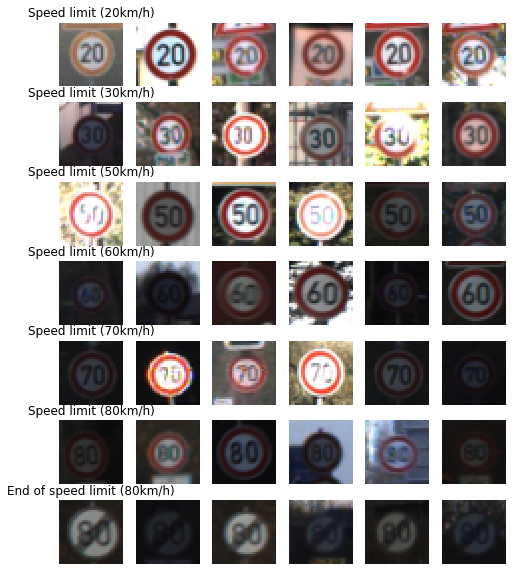

In [5]:
show_images(x=X_train,y=y_train,samples_per_class=6,classes_to_show=list(range(0,7)))

In [6]:
def plot_sample_per_class(y,title="Disribution of Samples for Each Class"):
    sign_df = pd.read_csv(sign_name_file)
    y_df = pd.DataFrame(y)
    y_df = y_df.rename(index=str, columns={0:"ClassId"})
    y_labeled_df = pd.merge(left=y_df,
                                 right=sign_df)
    y_sign_count = y_labeled_df.groupby(['SignName']).agg(['count'])
    y_sign_count.sort_values([('ClassId','count')], ascending=True, inplace=True)
    y_sign_count.plot.barh(figsize=(10,10));
    plt.title(title)
    pass

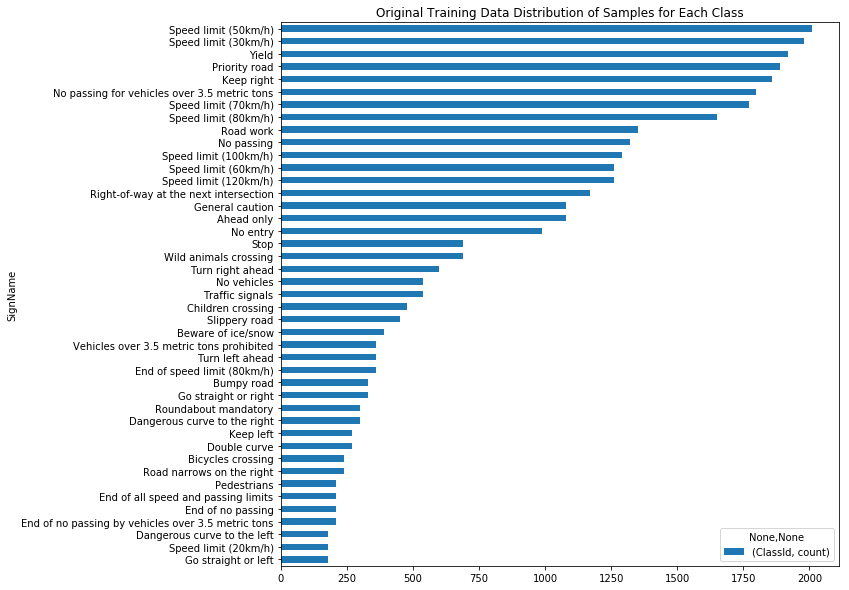

In [7]:
plot_sample_per_class(y_train, "Original Training Data Distribution of Samples for Each Class")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
'''
generate more data with rotate, shift, 
'''
def translate_image(image, shift_x, shift_y):
    '''
    : image
    '''
    height,width = image.shape[0:2]
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    new_image = cv2.warpAffine(image,M,(width,height))
    return new_image

def rotate_image(image,angle):
    '''
    '''
    height, width = image.shape[0:2]
    M = cv2.getRotationMatrix2D(center=(width/2,height/2),angle=angle,scale=1)
    new_image = cv2.warpAffine(image,M,(width,height))
    return new_image

"""def generate_data_for_label(x, y, label,num_new):
    '''
    : x: set of original images (4 dimensions: batch, height, width, channel)
    : y: labels (integers 1 to 43)
    : label: class label to generate data for.
    : 
    : return: tuple of new images and new labels
    '''
    idx_label = (y == label)
    original_images = x[idx_label]
    num_original = original_images.shape[0]
    new_images = list()
    for count in range(num_new):
        i = np.random.uniform(low=0,high=num_original,size=1)
        original_image = original_images[i]

        shift_x = np.random.randint(low=-4, high=5)
        shift_y = np.random.randint(low=-4, high=5)
        translated_image = translate_image(original_image, shift_x,shift_y)
        
        angle = np.random.randint(low=-30, high=31)
        rotated_translated_image = rotate_image(translated_image,angle)
        
        new_images.append(rotated_translated_image)
    new_labels = np.repeat(label, repeats=num_new)
    new_images = np.asarray(new_images)
    return new_images, new_labels
"""
def count_images_for_label(y,label):
    idx_label = (y == label)
    count = np.sum(idx_label)
    return count

In [8]:
def transform_image(x, idx):
    original_image = x[idx]
    shift_x = np.random.randint(low=-3, high=4)
    shift_y = np.random.randint(low=-3, high=4)
    translated_image = translate_image(original_image, shift_x,shift_y)

    angle = np.random.randint(low=-15, high=16)
    transformed_image = rotate_image(translated_image,angle)
    return transformed_image

In [9]:
def get_class_idx(y):
    class_ids = set(y_train)
    class_idx = dict()
    for class_id in class_ids:
        class_idx[class_id] = np.where( y_train == class_id)[0]
    return class_idx

In [11]:
"""
def generate_balanced_data(x,y,target=2100):
    '''
    Originally, I tried to generate data so that all classes have the same number of images.
    This appears to have led to overfitting, as validation accuracy without image generation was .95,
    whereas accuracy with 2500 images for each class was .92.
    
    I will just generate images for the classes that have 1000 or fewer original images.
    I will also cycle through each original image once, instead of random selection, to avoid
    using the same original image more than once.
    
    Result of this method was slightly worse than when not generating any new data: 0.9469
    
    I'm going back to generating a balanced distribution and trying again.
    
    :x set of original images (4D: batch, heigh, width, channel)
    :y labels
    :target: minimum number of images desired for each class
    '''
    min_label = np.min(y)
    max_label = np.max(y)
    new_images_list = list()
    new_labels_list = list()
    for label in range(min_label,max_label+1):
        num_original = count_images_for_label(y,label)
        if original_count < target:
            num_new = target - num_original
            new_images, new_labels = generate_data_for_label(x,y,label,num_new)
            new_images_list.extend(new_images)
            new_labels_list.extend(new_labels)
    new_x = np.asarray(new_images_list)
    new_y = np.asarray(new_labels_list)
    return new_x, new_y
"""

"\ndef generate_balanced_data(x,y,target=2100):\n    '''\n    Originally, I tried to generate data so that all classes have the same number of images.\n    This appears to have led to overfitting, as validation accuracy without image generation was .95,\n    whereas accuracy with 2500 images for each class was .92.\n    \n    I will just generate images for the classes that have 1000 or fewer original images.\n    I will also cycle through each original image once, instead of random selection, to avoid\n    using the same original image more than once.\n    \n    Result of this method was slightly worse than when not generating any new data: 0.9469\n    \n    I'm going back to generating a balanced distribution and trying again.\n    \n    :x set of original images (4D: batch, heigh, width, channel)\n    :y labels\n    :target: minimum number of images desired for each class\n    '''\n    min_label = np.min(y)\n    max_label = np.max(y)\n    new_images_list = list()\n    new_labels_lis

In [10]:
def combine_original_new(original_x, new_x, original_y, new_y):
    '''
    4d arrays as input
    '''
    assert original_x.shape[1:] == new_x.shape[1:] and original_y.shape[1:] == new_y.shape[1:], \
        "Each item in original and new should have same dimensions:" + \
        "original_x.shape {}\t".format(original_x.shape) + \
        "new_x.shape {}\n".format(new_x.shape) + \
        "original_y.shape {}\t".format(original_y.shape) + \
        "new_y.shape {}\n".format(new_y.shape)
    
    combined_x = np.concatenate( (original_x, new_x), axis=0)
    combined_y = np.concatenate( (original_y, new_y), axis=0)
    return combined_x, combined_y

In [11]:
#re-scale data from range of 0 to 255 to a desired range
def rescale(data,in_left=0.,in_right=255.,out_left=-1.,out_right=1.):
    '''    
    '''
    in_left = float(in_left)
    in_right = float(in_right)
    out_left = float(out_left)
    out_right = float(out_right)
    new_data = (data - in_left) * (out_right - out_left) / (in_right - in_left) + out_left
    
    return new_data

def rescale_per_image(data, out_left=-1., out_right=1.):
    '''
    '''
    out_left = float(out_left)
    out_right = float(out_right)
    new_data = np.zeros(shape=data.shape)
    for ii in range(data.shape[0]):
        in_left = np.min(data[ii]) #get the minimum for all pixels of one image, for all 3 channels
        in_right = np.max(data[ii])
        data_reshaped = np.reshape(data[ii],[1,data.shape[1],data.shape[2],data.shape[3]])
        new_data[ii] = rescale(data_reshaped,in_left,in_right,out_left,out_right)
    return new_data

def grayscale(data):
    """
    http://scikit-image.org/docs/dev/api/skimage.color.html?highlight=rgb2gray#skimage.color.rgb2gray
    This weights green most heavily because human eyes also weight green most heavily
    Y = 0.2125 R + 0.7154 G + 0.0721 B
    Since the rgb2gray removes the channel dimension, I reshape it so that it has the 4th dimension
    """
    data_gray = rgb2gray(data)
    shape = data_gray.shape
    data_gray4d = np.reshape(data_gray,[shape[0],shape[1],shape[2],1])
    return data_gray4d


In [12]:
'''
Rescale each image so its min is -1 and max is 1
'''

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#try to rescale so that global min is -1, global max is -1
#does slightly worse than when rescaling each image to range from -1 to 1
#X_train = rescale(X_train)
#X_valid = rescale(X_valid)
#X_test = rescale(X_test)


X_train = rescale_per_image(X_train)
X_valid = rescale_per_image(X_valid)
X_test = rescale_per_image(X_test)

'''
Grayscale didn't seem to make a difference
#X_train = grayscale(X_train)
#X_valid = grayscale(X_valid)
#X_test = grayscale(X_test)
'''

X_train, y_train = shuffle(X_train, y_train)

image_shape = X_train.shape[1:4]

In [13]:
'''
Check some images to make sure their min and max are -1 and 1
'''
for j in range(0,3):
    i = np.random.randint(low=0,high=X_train.shape[0],size=1)
    print("train image {} min {} max {} ".format(i, np.min(X_train[i]), np.max(X_train[i])))


    i = np.random.randint(low=0,high=X_valid.shape[0],size=1)
    print("validation image {} min {} max {} ".format(i, np.min(X_valid[i]), np.max(X_valid[i])))

    i = np.random.randint(low=0,high=X_test.shape[0],size=1)
    print("test image {} min {} max {} ".format(i, np.min(X_test[i]), np.max(X_test[i])))


train image [5049] min -1.0 max 1.0 
validation image [969] min -1.0 max 1.0 
test image [9350] min -1.0 max 1.0 
train image [20950] min -1.0 max 1.0 
validation image [664] min -1.0 max 1.0 
test image [1947] min -1.0 max 1.0 
train image [770] min -1.0 max 1.0 
validation image [3581] min -1.0 max 1.0 
test image [11095] min -1.0 max 1.0 


In [14]:
# save transformed data
prepared_data_file = "traffic_sign_transformed_data.p"
pickle.dump( [X_train,y_train, X_valid, y_valid, X_test, y_test], open( prepared_data_file, "wb" ) )

# CheckPoint: load transformed data

In [25]:
'''

'''
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
%matplotlib inline 
import random
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from skimage import data

prepared_data_file = "traffic_sign_transformed_data.p"
X_train,y_train, X_valid, y_valid, X_test, y_test = pickle.load( open(prepared_data_file, "rb") )

"""
recalculate some other variables
"""
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

### Model Architecture

In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [15]:
'''
Constants
MU and SIGMA are the mean and stddev of the weights and biases
'''
MU = 0
SIGMA = 0.1

In [16]:
#Define inputs to the graph

def inputs_(image_shape, n_classes):
    """
    Create the placeholders for inputs whose data are 
    set by feed_dict before a call to session.run()
    : param: image_shape: a 3D tensor (height, width, channel depth)
    : return: tuple with x, y, keep_prob, and is_training
    """
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, image_shape[0], image_shape[1], image_shape[2]),
                       name='x')
    y = tf.placeholder(dtype=tf.int32,
                      shape=(None),
                      name='y')
    y_one_hot = tf.one_hot(y,n_classes)
    keep_prob = tf.placeholder(dtype=tf.float32,
                              shape=None,
                              name='keep_prob')
    is_training = tf.placeholder(dtype=tf.int8, shape=None, name='is_training')
    return (x,y,y_one_hot,keep_prob,is_training)

In [17]:
def conv2d_norm(x_tensor,
                      conv_num_outputs, 
                      conv_ksize, 
                      conv_strides,
                      is_training=False):
    """
    Apply convolution, then batch normalization, then activation on x_tensor input
    :param x_tensor: TensorFlow Tensor; input image, batch, height, width, depth
    :param conv_num_outputs: Number of outputs for the convolutional layer; output depth
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer; filter dimensions
    :param conv_strides: Stride 2-D Tuple for convolution
    :param is_training: set to True when training, False when testing, for batch normalization
    :return: A tensor that represents convolution and max pooling of x_tensor
    """

    '''
    use Tensor.get_shape().as_list() to get dimensions
    '''
    in_batch, in_height, in_width, in_depth = x_tensor.get_shape().as_list()
    conv_height, conv_width = conv_ksize[0], conv_ksize[1]
    weight = tf.Variable(tf.truncated_normal(shape=[conv_height,
                                                    conv_width,
                                                    in_depth,
                                                    conv_num_outputs],
                                             mean=MU,
                                             stddev=SIGMA))
    bias = tf.Variable(tf.truncated_normal(shape=[conv_num_outputs],
                                          mean=MU,
                                          stddev=SIGMA))
    
    #create convolutional layer
    conv_strides_height, conv_strides_width = conv_strides[0], conv_strides[1]
    conv_strides_batch = 1
    conv_strides_channel = 1
    conv_strides_ = [conv_strides_batch, 
                     conv_strides_height, 
                     conv_strides_width,
                     conv_strides_channel]
    
    
    #tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)
    conv_layer = tf.nn.conv2d(input=x_tensor,
                              filter=weight,
                              strides=conv_strides_,
                              padding='SAME')
    
    conv_layer_with_bias = tf.nn.bias_add(conv_layer, bias)
    
    #apply batch normalization after the linear step and before the non-linear activation
    conv_layer_norm = tf.contrib.layers.batch_norm(conv_layer,
                                              center=True,
                                              scale=True,
                                              is_training=is_training)
    #activation
    conv_layer_activation = tf.nn.relu(conv_layer_norm)
    return conv_layer_activation

In [18]:
def maxpool(conv_layer_activation,pool_ksize,pool_strides=None):
    """
    Apply max pooling to the convolutional layer
    Note that it makes more sense for the stride to be the same as the ksize,
    otherwise we end up with overlapping windows or skip parts of the image.
    
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool

    """
    #tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
    pool_stride_height, pool_stride_width = pool_ksize[0], pool_ksize[1]
    pool_stride_batch, pool_stride_channel = 1, 1
    pool_ksize_ = [pool_stride_batch,
                   pool_stride_height,
                   pool_stride_width,
                   pool_stride_channel]
    if pool_strides == None:
        pool_strides_ = pool_ksize_
    else:
        pool_stride_height, pool_stride_width = pool_strides[0], pool_strides[1]
        pool_stride_batch, pool_stride_channel = 1, 1
        pool_strides_ = [pool_stride_batch,
                         pool_stride_height,
                         pool_stride_width,
                         pool_stride_channel]

    pool_layer = tf.nn.max_pool(value=conv_layer_activation,
                               ksize=pool_ksize_,
                               strides=pool_strides_,
                               padding='SAME')
    return pool_layer

In [19]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    Flatten layer prepares the convolutional output to be input for the fully connected layer.
    Convolutional output is 4 dimensions: batch, height, width, channel.
    The fully connected layer should take in 2D: batch, all data points (height * width * channel)
    Note that we can also use the existing function: tf.contrib.layers.flatten to do the same thing.
    Writing this function helps to show what it's doing.
    
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    batch, height, width, depth = x_tensor.get_shape().as_list()
    num_inputs = height * width * depth
    
    '''
    The inputs are along the columns, the num of rows are num of images for one batch.
    Use -1 in reshape to choose number of rows based on the size of x_tensor, 
    while making sure that num of columns equals number of pixel inputs for a single image.
    '''
    x_flat = tf.reshape(x_tensor, [-1, num_inputs])
    return x_flat

In [20]:
def fully_conn_norm(x_tensor, num_outputs, is_training=True):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    Also apply batch normalization before adding activation.
    : x_tensor: A 2-D tensor where the first dimension is batch size.
      x_tensor is a flattened image, where each row contains one image.
    : num_outputs: The number of output that the new tensor should be.
    : is_training: set to True during training, False during testing
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    batch, num_inputs = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal(shape=[num_inputs,num_outputs],
                                              mean=MU,
                                              stddev=SIGMA))
    bias = tf.Variable(tf.truncated_normal(shape=[num_outputs],
                                           mean=MU,
                                           stddev=SIGMA))
    fc = tf.matmul(x_tensor, weights)
    fc = tf.nn.bias_add(fc,bias)
    
    #perform batch normalization before the non-linear activation
    fc = tf.contrib.layers.batch_norm(fc, center=True, scale=True, is_training=is_training)
    
    #include activation
    fc = tf.nn.relu(fc)
    return fc

In [21]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    batch, num_inputs = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal(shape=[num_inputs, num_outputs],
                                              mean=MU,
                                              stddev=SIGMA))
    bias = tf.Variable(tf.truncated_normal(shape=[num_outputs],
                                          mean=MU,
                                          stddev=SIGMA))
    logits = tf.matmul(x_tensor, weights)
    logits = tf.nn.bias_add(logits, bias)
    #do not include non-linear activation to output
    return logits

In [28]:
def conv_net(x, keep_prob, is_training_flag=0):
    """
    Create a convolutional neural network model
    1x1 filter of depth 3: https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad
    
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : is_training: set to 1 during training, 0 during testing (for batch normalization in hidden layers)
      I used an integer and translate to boolean because I had problems when passing a boolean into feed_dict
      when running a session.
    : return: Tensor that represents logitsfd
    """
    is_training = False if is_training_flag == 0 else True
    
    '''
    #apply 1x1 filter with depth 3 
    color_map = conv2d_norm(x_tensor=x,
                          conv_num_outputs=3,
                          conv_ksize=(1,1),
                          conv_strides=(1,1),
                          is_training=is_training)
    '''
    # Apply convolutional layers with batch normalization, max pooling, and dropout
    conv1 = conv2d_norm(x_tensor=x,
                        conv_num_outputs=64, 
                        conv_ksize=(3,3), 
                        conv_strides=(1,1),
                        is_training=is_training)
    pool1 = maxpool(conv1,
                    pool_ksize=(2,2))
    drop1 = tf.nn.dropout(pool1,
                          keep_prob)
    
    conv2 = conv2d_norm(x_tensor=drop1,
                        conv_num_outputs=128,
                        conv_ksize=(3,3), 
                        conv_strides=(1,1),
                        is_training=is_training)
    pool2 = maxpool(conv2,
                    pool_ksize=(2,2))
    drop2 = tf.nn.dropout(pool2,
                          keep_prob)
    
    conv3 = conv2d_norm(x_tensor=drop2,
                        conv_num_outputs=256, 
                        conv_ksize=(3,3), 
                        conv_strides=(1,1),
                        is_training=is_training)
    pool3 = maxpool(conv3,
                    pool_ksize=(3,3))
    drop3 = tf.nn.dropout(conv3, keep_prob)
    
    # Flatten Layer to prepare convolutional output as input to fully connected layer
    flat = flatten(x_tensor=conv3)

    # Fully connected layers
    fc1 = fully_conn_norm(x_tensor=flat, num_outputs=2048, is_training=is_training)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn_norm(x_tensor=fc1, num_outputs=1024, is_training=is_training)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    #fc3 = fully_conn_norm(x_tensor=fc2, num_outputs=2048, is_training=is_training)
    #fc3 = tf.nn.dropout(fc3, keep_prob)
    
    # Apply an Output Layer
    #    Set this to the number of classes
    logits = output(x_tensor=fc2, num_outputs=n_classes)
    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(logits, name='logits')

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [27]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

Notes on performance

Try 1
Epochs 20, batch size 1024, color (3 channels), learning rate 0.01, keep_prob 0.50.
Reached valid acc .85 at epoch 17, ended at epoch 20 with acc .84.

Epoch 17, Batch 12:  loss 0.0017, validation accuracy 0.8537

Epoch 20, Batch 34:  loss 0.0006, validation accuracy 0.8469

Try 2
Epochs 20, batch size 1024, learn rate .01, keep_prob 0.50, but grayscale (1 channel).  Valid acc improves more quickly, and reaches .84 at epoch 12.  At Epoch 20, still at .8451 accuracy.

Epoch 20, Batch 34:  loss 0.0025, validation accuracy 0.8451

Note that for the previous 1 cases, I found that my rescaling was incorrect, because when I pass in integers for the parameters, the scaling wasn't working; it worked if I convert them to float.

Try 3
I'm rescaling per image, so each image's min is -1 and each image's max is 1.
Epochs 20, batch size 1024, color (3 channels), learning rate 0.01, keep_prob 0.50.  Using color (all 3 channels)
At Epoch 12, getting valida acc .95.  It's pretty much hovering around that ever since Epoch 12.  Next time I can do tests with just 12 epochs to save time on experimenting.

Epoch 12, Batch 17:  loss 0.0018, validation accuracy 0.9510

Epoch 17, Batch 24:  loss 0.0004, validation accuracy 0.9535

Epoch 20, Batch 34:  loss 0.0003, validation accuracy 0.9578

Try 4:
Rotate, shift, and add light to images, make number of samples equal for each label.

In [86]:
"""
Hyper parameters
"""
LEARNING_RATE=0.01
LINE_WIDTH = 120
"""
Training pipeline:
Build the network, define the cost, and create the optimizer that will minimize this cost.
Also define the accuracy measures.
"""

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x,y,y_one_hot,keep_prob,is_training = inputs_(image_shape, n_classes)

# Model and output
logits = conv_net(x, keep_prob, is_training)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot), name='cost')
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='optimizer').minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [30]:
def get_batch(x, y, batch_size):
    num_records = len(y)
    for ii in range(0, num_records, batch_size):
        x_batch, y_batch = x[ii:ii+batch_size], y[ii:ii+batch_size]
        yield x_batch, y_batch

In [31]:
def get_transformed_uniform_batch(x, y, fraction_transform=0.50, num_per_class=50):
    """
    From the original data, get a random and equal distribution for all classes (sample without replacement).
    Even the class with the smallest data (180) should have enough for one batch
    
    For a given percentage of each class, transform the image (translate/rotate).
    
    return the batch
    """
    idx_split = int(num_per_class * fraction_transform)
    batch_x = list()
    batch_y = list()
    class_idx = get_class_idx(y)
    for class_id, class_indices in class_idx.items():
        sample_idx = np.random.choice(class_indices, size=num_per_class, replace=False)
        if idx_split > 0:
            transform_idx, original_idx = sample_idx[0:idx_split], sample_idx[idx_split:]
            original_images = x[original_idx]
            original_labels = y[original_idx]
            new_images = list()
            for ii in transform_idx:
                transformed_image = transform_image(X_train,ii)
                new_images.append(transformed_image)

            new_images = np.asarray(new_images)
            new_labels = np.repeat(class_id, len(transform_idx))  #np.repeat(label, repeats=num_new)
            class_images, class_labels = combine_original_new(original_images, new_images, original_labels, new_labels)
        else:
            class_images, class_labels = x[sample_idx], y[sample_idx]
            
        batch_x.extend(class_images)
        batch_y.extend(class_labels)

    #shuffle
    batch_x, batch_y = shuffle(batch_x, batch_y)
    batch_x = np.asarray(batch_x)
    batch_y = np.asarray(batch_y)
    return batch_x, batch_y

In [32]:
'''
def get_transformed_batch(x, y, fraction_transform=0.50, batch_size=2048):
    """
    I originally tried randomly sampling batch_size from the original data set.
    I'm replacing this version with another one (see below)
    From the original data, get a random sample from the original data (don't try to equalizez the distribution)
    
    For a given percentage of each batch, transform the image (translate/rotate).
    
    return the batch
    """
    num_original = x.shape[0]
    idx_split = int(fraction_transform * batch_size)
    batch_x = list()
    batch_y = list()
    sample_idx = np.random.choice(range(num_original), size=batch_size, replace=False)
    if idx_split > 0:
        transform_idx, original_idx = sample_idx[0:idx_split], sample_idx[idx_split:]
        original_images = x[original_idx]
        original_labels = y[original_idx]
        new_images = list()
        new_labels = list()
        for ii in transform_idx:
            transformed_image = transform_image(X_train,ii)
            new_images.append(transformed_image)
            new_labels.append(y[ii])

        new_images = np.asarray(new_images)
        new_labels = np.asarray(new_labels)
        class_images, class_labels = combine_original_new(original_images, new_images, original_labels, new_labels)
    else:
        class_images, class_labels = x[sample_idx], y[sample_idx]
            
    #shuffle
    batch_x, batch_y = shuffle(class_images, class_labels)
    batch_x, batch_y = np.asarray(batch_x), np.asarray(batch_y)
    return batch_x, batch_y
'''

'\ndef get_transformed_batch(x, y, fraction_transform=0.50, batch_size=2048):\n    """\n    I originally tried randomly sampling batch_size from the original data set.\n    I\'m replacing this version with another one (see below)\n    From the original data, get a random sample from the original data (don\'t try to equalizez the distribution)\n    \n    For a given percentage of each batch, transform the image (translate/rotate).\n    \n    return the batch\n    """\n    num_original = x.shape[0]\n    idx_split = int(fraction_transform * batch_size)\n    batch_x = list()\n    batch_y = list()\n    sample_idx = np.random.choice(range(num_original), size=batch_size, replace=False)\n    if idx_split > 0:\n        transform_idx, original_idx = sample_idx[0:idx_split], sample_idx[idx_split:]\n        original_images = x[original_idx]\n        original_labels = y[original_idx]\n        new_images = list()\n        new_labels = list()\n        for ii in transform_idx:\n            transformed

In [61]:
def get_transformed_batch(x, y, fraction_transform=0.10, batch_size=2048):
    """
    Still need to test this
    This version does not randomly sample batch_size; instead it iterates
    through the original data set and yields each batch.
    For a given percentage of each batch, transform the image (translate/rotate).
    Shuffle before splitting, so each epoch transforms different images.
    yield the batch
    """
    num_records = x.shape[0]
    idx_split = int(fraction_transform * batch_size)
    for ii in range(0, num_records, batch_size):
        x_batch, y_batch = x[ii:ii+batch_size], y[ii:ii+batch_size]
        if idx_split > 0:
            x_batch, y_batch = shuffle(x_batch, y_batch)
            original_images, original_labels = x_batch[idx_split:], y_batch[idx_split:]
            new_images_raw, new_labels       = x_batch[:idx_split], y_batch[:idx_split]
            new_images = list()
            for jj in range(new_images_raw.shape[0]):
                new_images.append(transform_image(new_images_raw,jj))

            new_images = np.asarray(new_images)
            x_batch, y_batch = combine_original_new(original_images, new_images, original_labels, new_labels)
            x_batch, y_batch = shuffle(x_batch, y_batch)
        
        yield x_batch, y_batch

In [34]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    feed_dictionary = {x : feature_batch,
                       y : label_batch,
                       keep_prob : keep_probability,
                       is_training : 1
                      }
    session.run(optimizer, feed_dict=feed_dictionary)

In [35]:
def get_batch_loss_accuracy(session, feature_batch, label_batch, cost, accuracy):
    """
    Calculate loss and accuracy.  This works for training batches and validation,
    when the size of data isn't an issue for memory
    
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    feed_dict = {x: feature_batch, 
                 y: label_batch, 
                 keep_prob: 1.}
    batch_loss, batch_accuracy = session.run([cost,accuracy], feed_dict=feed_dict)
    #print("training loss {:.4f}, accuracy {:.4f}".format(batch_loss, batch_accuracy))
    return batch_loss, batch_accuracy

In [36]:
def print_batch_info(epoch, batch_i, batch_train_loss, batch_train_accuracy, valid_loss, valid_accuracy):
    print('Epoch {:>2}, Batch {:>2}: '.format(epoch, batch_i), end='')
    print("batch training loss {:.4f}, ".format(batch_train_loss), end='')
    print("accuracy {:.4f}; ".format(batch_train_accuracy), end='')
    print("validation loss {:.4f}, ".format(valid_loss), end='')
    print("accuracy {:.4f}.".format(valid_accuracy), end='\n')

In [37]:
def get_average_loss_accuracy(session, features, labels, cost, accuracy, batch_size):
    """
    Calculate total loss and accuracy by first calculating in small batches, to avoid memory issues
    
    For each batch, scale results by number of records in each batch (the last batch may not be the full batch_size)
    Then after all batches are calculated, divide by total num of records so that each record has the same weight
    in the total loss and accuracy.
    """
    assert features.shape[0] == labels.shape[0], \
        "features {} and labels {} should have the same length".format(features.shape[0], labels.shape[0])
    total_accuracy = 0
    total_loss = 0
    num_records = features.shape[0]
    for ii in range(0, num_records, batch_size):
        batch_x, batch_y = features[ii:ii+batch_size], labels[ii:ii+batch_size]
        feed_dict = {x: batch_x,
                     y: batch_y,
                     keep_prob: 1.}
        batch_loss, batch_accuracy = session.run([cost, accuracy], feed_dict=feed_dict)
        num_in_this_batch = batch_x.shape[0]
        total_loss += batch_loss * num_in_this_batch
        total_accuracy += batch_accuracy * num_in_this_batch
        
    average_loss = float(total_loss) / num_records
    average_accuracy = float(total_accuracy) / num_records
    return average_loss, average_accuracy

In [85]:
def print_epoch_info(epoch, training_loss, training_accuracy, validation_loss, validation_accuracy):
    print("-" * LINE_WIDTH)
    print("Average for Epoch {:>2}: ".format(epoch), end='')
    print("Training loss = {:.4f}, ".format(training_loss), end='')
    print("accuracy = {:.4f}; ".format(training_accuracy), end='')
    print("Validation loss = {:.4f}, ".format(validation_loss), end='')
    print("accuracy = {:.4f}".format(validation_accuracy), end='\n')
    print("-" * LINE_WIDTH)

In [39]:
def plot_loss_accuracy(epochs, training_loss_history, training_accuracy_history, validation_loss_history, validation_accuracy_history):
    
    f, (loss_plot, acc_plot) = plt.subplots(2, 1, figsize=(10,8))
    loss_plot.set_title('Loss')
    loss_plot.plot(training_loss_history, 'r', label='Training Loss')
    loss_plot.plot(validation_loss_history, 'b', label='Validation Loss')
    loss_plot.set_xlim([0, epochs])
    loss_plot.legend(loc=4)
    
    acc_plot.set_title('Accuracy')
    acc_plot.plot(training_accuracy_history,'r', label='Training Accuracy')
    acc_plot.plot(validation_accuracy_history, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([0, epochs])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

In [84]:
"""
Run training
"""
def train_and_evaluate(session, 
                       X_train,y_train,
                       X_valid,y_valid, 
                       epoch_start = 1, epoch_end = 20,
                       fraction_transform=0.50, batch_size=2048,
                       training_loss_history=[], validation_loss_history=[], 
                       training_accuracy_history=[], validation_accuracy_history=[]):
    start = datetime.now()
    #with tf.Session() as session:
    #    session.run(tf.global_variables_initializer())

    for epoch in range(epoch_start,epoch_end):
        print("*" * LINE_WIDTH)
        print("epoch {}".format(epoch))
        print("start time {}".format(start))
        print('Fraction transformed is {:.2f}, Training...'.format(fraction_transform))

        batch_i = 0
        loss_one_epoch  = 0
        valid_acc_one_epoch = 0
        X_train, y_train = shuffle(X_train, y_train)
        for features_batch, labels_batch in get_transformed_batch(X_train, y_train, fraction_transform, batch_size):
            batch_i +=1
            train_neural_network(session, optimizer, TRAIN_KEEP_PROB, features_batch, labels_batch)
            if batch_i % 100 == 0: #don't use up runtime on batch evaluation
                batch_train_loss, batch_train_accuracy = get_batch_loss_accuracy(session, 
                                                                     features_batch, 
                                                                     labels_batch, 
                                                                     cost, 
                                                                     accuracy)
                valid_loss, valid_accuracy = get_batch_loss_accuracy(session,
                                                                    X_valid,
                                                                    y_valid,
                                                                    cost,
                                                                    accuracy)
                print_batch_info(epoch, batch_i, batch_train_loss, batch_train_accuracy, valid_loss, valid_accuracy)

            ###end for loop batches
        # Training Loss and Accuracy over entire epoch
        training_loss, training_accuracy = get_average_loss_accuracy(session,
                                                                     X_train,
                                                                     y_train,
                                                                     cost,
                                                                     accuracy,
                                                                     batch_size)
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)
        #Validation set is small enough that we don't have to average over batches
        validation_loss, validation_accuracy = get_batch_loss_accuracy(session,
                                                                       X_valid,
                                                                       y_valid,
                                                                       cost,
                                                                       accuracy)
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(validation_accuracy)
        print_epoch_info(epoch, training_loss, training_accuracy, validation_loss, validation_accuracy)
        ###end for loop epochs

    # Save Model
    #saver = tf.train.Saver()
    #save_path = saver.save(session, save_model_path)
    #print('saved graph' + save_model_path)
    endtime = datetime.now()
    print("end time {}; runtime {}".format(endtime, endtime - start))
    print("*" * LINE_WIDTH + "\n")
    return training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history

In [76]:
def train_and_evaluate_original(session,
                   X_train,y_train,
                   X_valid,y_valid, 
                   epoch_start,epoch_end,
                   batch_size,
                   training_loss_history, validation_loss_history, 
                   training_accuracy_history, validation_accuracy_history):
    start = datetime.now()
    

    #with tf.Session() as session:
    #    session.run(tf.global_variables_initializer())

    for epoch in range(epoch_start,epoch_end):
        print("*" * 60)
        print("epoch {}".format(epoch))
        print("start time {}.  Training...".format(start))
        batch_i = 0
        loss_one_epoch  = 0
        valid_acc_one_epoch = 0
        X_train, y_train = shuffle(X_train, y_train)
        for features_batch, labels_batch in get_batch(X_train, y_train, batch_size):
            batch_i +=1
            train_neural_network(session, optimizer, TRAIN_KEEP_PROB, features_batch, labels_batch)
            
            if batch_i % 100 == 0: #just don't print batch progress to save time
                batch_train_loss, batch_train_accuracy = get_batch_loss_accuracy(session, 
                                                                     features_batch, 
                                                                     labels_batch, 
                                                                     cost, 
                                                                     accuracy)
                valid_loss, valid_accuracy = get_batch_loss_accuracy(session,
                                                                    X_valid,
                                                                    y_valid,
                                                                    cost,
                                                                    accuracy)
                print_batch_info(epoch, batch_i, batch_train_loss, batch_train_accuracy, valid_loss, valid_accuracy)
            ###end for loop batches
        # Training Loss and Accuracy over entire epoch
        training_loss, training_accuracy = get_average_loss_accuracy(session,
                                                                     X_train,
                                                                     y_train,
                                                                     cost,
                                                                     accuracy,
                                                                     batch_size)
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)
        #Validation set is small enough that we don't have to average over batches
        validation_loss, validation_accuracy = get_batch_loss_accuracy(session,
                                                                       X_valid,
                                                                       y_valid,
                                                                       cost,
                                                                       accuracy)
        validation_loss_history.append(validation_loss)
        validation_accuracy_history.append(validation_accuracy)
        print_epoch_info(epoch, training_loss, training_accuracy, validation_loss, validation_accuracy)
        ###end for loop epochs

    # Save Model
    #saver = tf.train.Saver()
    #save_path = saver.save(session, save_model_path)
    #print('saved graph' + save_model_path)
    endtime = datetime.now()
    print("end time {}; runtime {}".format(endtime, endtime - start))
    print("*" * 60)
    return training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history

In [88]:
def iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size=2048,
                           fraction_transform = 0.10,
                           save_file_prefix='traffic_sign'):
    """
    Train one epoch at a time and save graph after each epoch
    """
    start_time = datetime.now()
    training_loss_history, validation_loss_history = [], []
    training_accuracy_history, validation_accuracy_history = [], []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epoch_start,epoch_end+1):
            save_model_path = './' + save_file_prefix + '_epoch_{0:02d}'.format(epoch)
            epoch_next = epoch+1
            training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history = \
            train_and_evaluate(session,
                               X_train,y_train,
                               X_valid,y_valid, 
                               epoch,epoch_next,
                               fraction_transform, batch_size,
                               training_loss_history, validation_loss_history, 
                               training_accuracy_history, validation_accuracy_history)
            #fraction_transform = max(0.10, fraction_transform - 0.05)
            if epoch > (epoch_end - 6):
                saver = tf.train.Saver()
                save_path = saver.save(session, save_model_path)
                print('epoch {}, saved graph'.format(epoch) + save_model_path )
        plot_loss_accuracy(epoch_end, training_loss_history, training_accuracy_history, validation_loss_history, validation_accuracy_history)
        end_time = datetime.now()
        print("***************************************************")
        print("global start time {}, end time {} total run time {}".format(start_time,end_time,end_time-start_time))

In [48]:
def iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data'):
    """
    Train one epoch at a time and save graph after each epoch
    """
    start_time = datetime.now()
    training_loss_history, validation_loss_history = [], []
    training_accuracy_history, validation_accuracy_history = [], []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epoch_start,epoch_end+1):
            save_model_path = './' + save_file_prefix + '_epoch_{0:02d}'.format(epoch)
            epoch_next = epoch+1            
            training_loss_history, validation_loss_history, training_accuracy_history, validation_accuracy_history = \
            train_and_evaluate_original(session,
                               X_train,y_train,
                               X_valid,y_valid, 
                               epoch,epoch_next,
                               batch_size,
                               training_loss_history, validation_loss_history, 
                               training_accuracy_history, validation_accuracy_history)
            if epoch > (epoch_end - 6):
                saver = tf.train.Saver()
                save_path = saver.save(session, save_model_path)
                print('epoch {}, saved graph'.format(epoch) + save_model_path )
        plot_loss_accuracy(epoch_end, training_loss_history, training_accuracy_history, validation_loss_history, validation_accuracy_history)
        end_time = datetime.now()
        print("***************************************************")
        print("global start time {}, end time {} total run time {}".format(start_time,end_time,end_time-start_time))

## Trial 1

In [ ]:
'''
Trained using 2500 images for each class.  

3 fully connected layers

Probably generated too many of the same images for the classes that had very few original images.
Looks like it's overfitting, because training accuracy reached 1.0 and validation accuracy hovered around 0.92 to 0.93.
Average for Epoch 10: Training loss = 0.0049, accuracy = 0.9986;Validation loss = 0.3813, accuracy = 0.9259
'''
EPOCHS = 20
BATCH_SIZE = 2048
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

train_and_evaluate(X_train,y_train,X_valid,y_valid, epochs=EPOCHS, batch_size=BATCH_SIZE)

## Trial 2

In [ ]:
'''
Train with images generated, one new image for each original image, 
only for classes that had fewer than 800 original images.

3 fully connected layers

Average for Epoch 20: Training loss = 0.0029, accuracy = 0.9992;Validation loss = 0.2575, accuracy = 0.9469
'''
EPOCHS = 20
BATCH_SIZE = 2048
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

iterate_train_evaluate(epoch_start=1,epoch_end=EPOCHS,
                       X_train=X_train,y_train=y_train,
                       X_valid=X_valid,y_valid=y_valid,
                       batch_size=BATCH_SIZE,
                       save_file_prefix='traffic_sign')

## Trial 3

In [ ]:
'''
Try to learn at a slower rate, more epochs.  Too slow, and performance doesn't necessarily improve.

3 fully connected layers

Average for Epoch 30: Training loss = 0.0848, accuracy = 0.9735;Validation loss = 0.3746, accuracy = 0.8950
'''
EPOCHS = 30
BATCH_SIZE = 2048
LEARNING_RATE = 0.001
TRAIN_KEEP_PROB = 0.50

iterate_train_evaluate(epoch_start=1,epoch_end=EPOCHS,
                       X_train=X_train,y_train=y_train,
                       X_valid=X_valid,y_valid=y_valid,
                       batch_size=BATCH_SIZE,
                       save_file_prefix='model_learn_rate_001')

## Trial 4

In [ ]:
"""
Train using random batches where a fraction of the images are transformed,
and there is an equal number of samples for each class

2 fully connected layers

"""
EPOCHS=22
LEARNING_RATE = 0.001
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
class_idx = get_class_idx(y_train)
num_classes = len(class_idx)
num_per_class = 50 #num of images per class to sample for each batch
batch_size = num_per_class * num_classes
fraction_transform = 0.90 #will decrease by 0.10 each epoch
num_batches = 10 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,  num_per_class,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 5

In [ ]:
"""
Train using random batches where a fraction of the images are transformed,
and there is an equal number of samples for each class
Previous trial didn't train enough times.

2 fully connected layers

Increase epochs to 30, num_per_class stays 50 (else memory overflow), num_batches per epoch 20
"""
EPOCHS=30
LEARNING_RATE = 0.001
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
num_classes = len(class_idx)
num_per_class = 50 #num of images per class to sample for each batch
batch_size = num_per_class * num_classes
fraction_transformed = 0.90 #will decrease by 0.10 each epoch
num_batches = 20 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,  num_per_class,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 6

In [ ]:
"""
Train using random batches where a fraction of the images are transformed,
and there is an equal number of samples for each class
Previous trial didn't train enough times.

2 fully connected layers

Increase epochs to 30, num_per_class stays 50 (else memory overflow), num_batches per epoch 40
"""
EPOCHS=30
LEARNING_RATE = 0.001
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
num_classes = len(class_idx)
num_per_class = 50 #num of images per class to sample for each batch
batch_size = num_per_class * num_classes
fraction_transformed = 0.90 #will decrease by 0.10 each epoch
num_batches = 40 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,  num_per_class,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 7

In [ ]:
"""
Trial 6 still trained too slowly; 19 hours long.  I'll try increasing the learning rate to .01.
To save time, I'll reduce to 20 batches per epoch.

2 fully connected layers

Train using random batches where a fraction of the images are transformed,
and there is an equal number of samples for each class
Previous trial didn't train enough times.

Increase epochs to 30, num_per_class stays 50 (else memory overflow), num_batches per epoch 40
"""
EPOCHS=30
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
num_classes = len(class_idx)
num_per_class = 50 #num of images per class to sample for each batch
batch_size = num_per_class * num_classes
fraction_transformed = 0.90 #will decrease by 0.10 each epoch
num_batches = 20 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,  num_per_class,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 8
keep original distribution class

In [ ]:
"""
So far, it seems like trying to get an equal distribution for each class has made things worse.
I'll try random batches with new images translated/rotated, but will not try to keep the same
number of samples per class.

I also added back the 3rd fully connected layer
Learning rate .005
"""
EPOCHS=20
LEARNING_RATE = 0.005
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048
fraction_transformed = 0.90 #will decrease by 0.10 each epoch
num_batches = 20 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 9

In [ ]:
"""
The previous trial got 91% accuracy, and might have still had more room to improve.
Runtime was 3.5 hours, so I can afford to run it a bit longer.  
Increasing num_batches per epoch from 20 to 40
Decreasing learning rate from .005 to .001
Increase epochs to 30

Random batches with new images translated/rotated, but will not try to keep the same
number of samples per class.
I also added back the 3rd fully connected layer
Learning rate .001

My internet connection was lost at epoch 27, so it never finished. 
But it looks like using learning rate of .001 is too slow; I can't use this given the time
it takes me to train and experiment.  I'll stay with learning rate .01 for learning purposes.

"""
EPOCHS=30
LEARNING_RATE = 0.001
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048
fraction_transformed = 0.90 #will decrease by 0.10 each epoch
num_batches = 40 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 10

start time 2017-04-27 16:11:52.815300
Fraction transformed is 0.90, Training...
Epoch  1, Batch  1: batch training loss 4.4916, accuracy 0.1953; validation loss 5.1813, accuracy 0.1973.
Epoch  1, Batch  2: batch training loss 4.6356, accuracy 0.1787; validation loss 4.9491, accuracy 0.2107.
Epoch  1, Batch  3: batch training loss 4.1528, accuracy 0.1895; validation loss 4.5080, accuracy 0.2029.
Epoch  1, Batch  4: batch training loss 3.7513, accuracy 0.2256; validation loss 4.2063, accuracy 0.2027.
Epoch  1, Batch  5: batch training loss 3.8097, accuracy 0.1763; validation loss 4.3108, accuracy 0.1522.
Epoch  1, Batch  6: batch training loss 3.2299, accuracy 0.1895; validation loss 3.6715, accuracy 0.1624.
Epoch  1, Batch  7: batch training loss 3.2309, accuracy 0.2256; validation loss 3.6133, accuracy 0.2143.
Epoch  1, Batch  8: batch training loss 3.1853, accuracy 0.2383; validation loss 3.3225, accuracy 0.2222.
Epoch  1, Batch  9: batch training loss 2.8545, accuracy 0.2573; validat

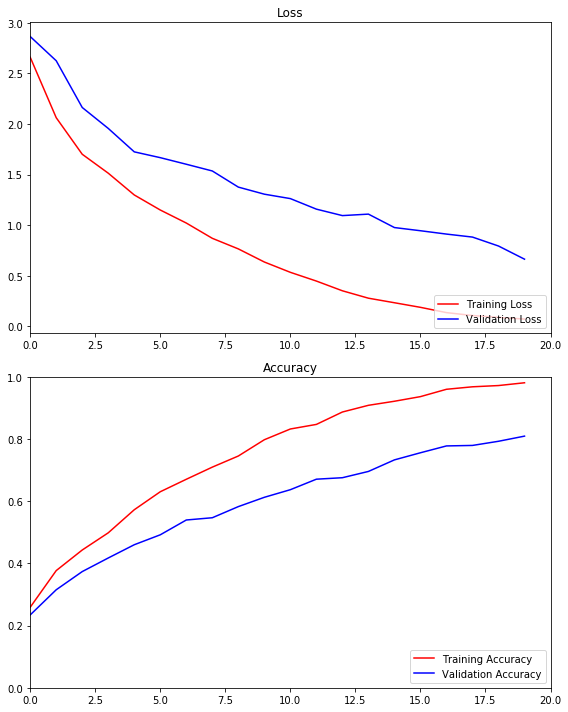

***************************************************
global start time 2017-04-27 16:11:51.437860, end time 2017-04-27 17:47:15.581063 total run time 1:35:24.143203


In [40]:
"""
I will try to keep at least 20% of images transformed for all epochs. So start with 90%, 80%, down to 20%
of images for each batch that are translated/transformed.

Using learning rate of .001 is really slow.  For experimenting, I want to run faster just to see how results
compare to the case when I don't transform any of the data and don't take random samples for batches. 

num_batches per epoch 20
learning rate .01
Epochs 20

Rotation angles reduces from -30 to 31 to -15 to 16; 
shift reduced from -4 to 5 to -3 to 4

I will also reduce the rotation angles and translation shifts, so that the images aren't so different
from the originals.  I increasd fully connected layer size from 1024 to 2048. Increased convolution1 
from 32 to 64; conv 2 and 3 are size 128 and 128.

Random batches with new images translated/rotated, but will not try to keep the same
number of samples per class.

I will reduce the fraction transformed by .05 each epoch, instead of by .10.
It will have at least 0.20 of each batch transformed.

I'm making the model smaller so that it runs faster.  I removed the 3rd fc layer.
FC size is now 1024
CNN 1,2,3 sizes are now 32, 64, 128
I'll run 10 batches per epoch.

"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048
fraction_transform = 0.90 #will decrease by 0.05 each epoch
num_batches = 10 #number of batches to sample per epoch

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform,
                           num_batches,
                           save_file_prefix='model_random_transformed')

## Trial 11

start time 2017-04-28 01:00:08.501068.  Training...
Epoch  1, Batch  1: batch training loss 5.8075, accuracy 0.2261; validation loss 6.8156, accuracy 0.1925.
Epoch  1, Batch  2: batch training loss 6.4666, accuracy 0.1621; validation loss 7.7958, accuracy 0.1619.
Epoch  1, Batch  3: batch training loss 4.7711, accuracy 0.2256; validation loss 5.9177, accuracy 0.2075.
Epoch  1, Batch  4: batch training loss 4.0369, accuracy 0.2573; validation loss 5.1445, accuracy 0.2166.
Epoch  1, Batch  5: batch training loss 3.6642, accuracy 0.2461; validation loss 4.4076, accuracy 0.2002.
Epoch  1, Batch  6: batch training loss 3.1889, accuracy 0.2666; validation loss 3.7928, accuracy 0.2281.
Epoch  1, Batch  7: batch training loss 2.9584, accuracy 0.2837; validation loss 3.6715, accuracy 0.2476.
Epoch  1, Batch  8: batch training loss 2.9201, accuracy 0.2690; validation loss 3.6729, accuracy 0.2379.
Epoch  1, Batch  9: batch training loss 2.8645, accuracy 0.2666; validation loss 3.5374, accuracy 0.

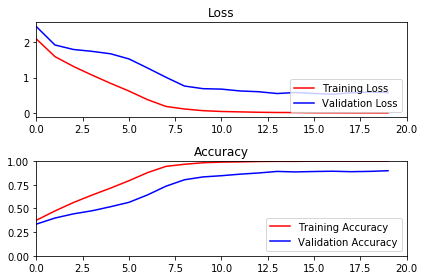

***************************************************
global start time 2017-04-28 01:00:07.242266, end time 2017-04-28 03:25:04.452004 total run time 2:24:57.209738


In [33]:
"""
Validation loss was not decreasing as rapidly as training loss in previous trial.

I'm going to go back to the original data set to go back to the original baseline performance.
Originally, with 3 fully connected layers, I got around 95% validation accuracy.

Here's i'm using cnn layers of size 32, 64, 128
fc layers of 1024 and 1024 (only 2 fc layers)

Average for Epoch 20: Training loss = 0.0029, accuracy = 0.9995; Validation loss = 0.5745, accuracy = 0.8973

"""

EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 12

start time 2017-04-28 12:35:55.047540.  Training...
Epoch  1, Batch  1: batch training loss 7.4995, accuracy 0.2139; validation loss 9.4382, accuracy 0.1744.
Epoch  1, Batch  2: batch training loss 11.5239, accuracy 0.1123; validation loss 13.1084, accuracy 0.0828.
Epoch  1, Batch  3: batch training loss 8.5594, accuracy 0.1611; validation loss 9.3664, accuracy 0.1408.
Epoch  1, Batch  4: batch training loss 7.7562, accuracy 0.1899; validation loss 7.5083, accuracy 0.1803.
Epoch  1, Batch  5: batch training loss 6.6753, accuracy 0.2075; validation loss 7.0893, accuracy 0.1741.
Epoch  1, Batch  6: batch training loss 5.8132, accuracy 0.1978; validation loss 6.9335, accuracy 0.1533.
Epoch  1, Batch  7: batch training loss 6.1730, accuracy 0.2070; validation loss 7.1356, accuracy 0.1703.
Epoch  1, Batch  8: batch training loss 4.7442, accuracy 0.2451; validation loss 5.6551, accuracy 0.2002.
Epoch  1, Batch  9: batch training loss 4.2778, accuracy 0.2549; validation loss 4.8335, accuracy 

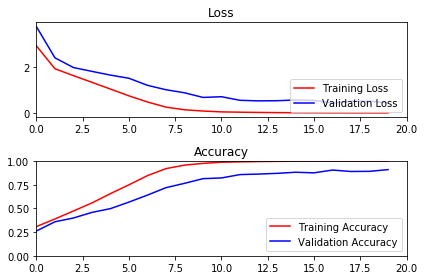

***************************************************
global start time 2017-04-28 12:35:52.945281, end time 2017-04-28 17:53:41.708528 total run time 5:17:48.763247


In [41]:
"""
Previous trial was over-fitting to training data, and validation accuracy wasn't improving.

I'm still using original data set. I'm increasing the size of the cnn to the way I tried it before:
cnn layer 1,2,3 have size 32, 128, 128
fc layers have size 2048, 2048, 2048 (3 layers)

Also, at the start of each epoch i shuffle the training data, so that each batch #1 does not contain the same 
data points as batch #1 from any other epoch.

I'll run 20 epochs. Save network for the last 5 epochs only (to save hard drive space)

Average for Epoch 20: Training loss = 0.0016, accuracy = 0.9997; Validation loss = 0.4303, accuracy = 0.9093

"""

EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 13

start time 2017-04-28 18:37:05.720619.  Training...
Epoch  1, Batch  1: batch training loss 7.8280, accuracy 0.1846; validation loss 9.8773, accuracy 0.1333.
Epoch  1, Batch  2: batch training loss 12.4928, accuracy 0.1416; validation loss 15.5176, accuracy 0.1129.
Epoch  1, Batch  3: batch training loss 9.3591, accuracy 0.1709; validation loss 10.7598, accuracy 0.1669.
Epoch  1, Batch  4: batch training loss 9.6033, accuracy 0.1162; validation loss 11.0320, accuracy 0.0746.
Epoch  1, Batch  5: batch training loss 8.4280, accuracy 0.0967; validation loss 8.5713, accuracy 0.1111.
Epoch  1, Batch  6: batch training loss 6.7664, accuracy 0.1182; validation loss 7.1883, accuracy 0.0766.
Epoch  1, Batch  7: batch training loss 5.8039, accuracy 0.1133; validation loss 6.6939, accuracy 0.1018.
Epoch  1, Batch  8: batch training loss 5.6450, accuracy 0.1367; validation loss 6.3927, accuracy 0.1229.
Epoch  1, Batch  9: batch training loss 5.4756, accuracy 0.1543; validation loss 5.8843, accurac

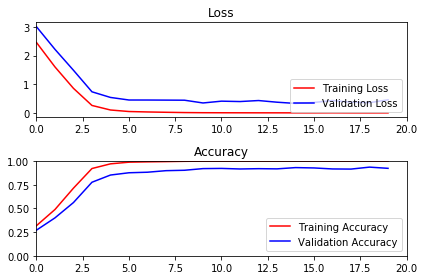

***************************************************
global start time 2017-04-28 18:37:04.319123, end time 2017-04-28 23:46:19.953291 total run time 5:09:15.634168


In [48]:
"""
If original data set is around 95% accuracy, then I can try adding data transformation, maybe just 10% of each batch.
If I still don't get back to 95% validation accuracy, then I can remove the colormap layer, since that 
wasn't in my initial model.

Since Trial 12 only reached 90% validation accuracy, I'm removing the colormap layer to go back to
what I had when i first started.  Still trying to get back to 95%.
Conv net had 3 colors and no color map layer.  Had 3 fc layers.  conv net layers were 64, 128, 128.
batch size was 1024.  It reached 95% around epoch 12 and also stayed that way at epoch 20.  Learning rate .01,
keep_prob was .50.

So far so good; looks like the colormap that I added was making validation accuracy lower.
It's removed for this current trial.

I first reach 93% at epoch 16, and again at epoch 19
Epoch 16, Batch 16: batch training loss 0.0009, accuracy 1.0000; validation loss 0.3661, accuracy 0.9331.
Average for Epoch 19: Training loss = 0.0007, accuracy = 0.9999; Validation loss = 0.3563, accuracy = 0.9354
Average for Epoch 20: Training loss = 0.0012, accuracy = 0.9999; Validation loss = 0.4566, accuracy = 0.9227

"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 1024

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 14

start time 2017-04-29 00:21:07.277301.  Training...
Epoch  1, Batch 10: batch training loss 6.1682, accuracy 0.0811; validation loss 7.6168, accuracy 0.0578.
Epoch  1, Batch 20: batch training loss 4.0832, accuracy 0.0791; validation loss 5.6393, accuracy 0.0551.
Epoch  1, Batch 30: batch training loss 3.6066, accuracy 0.1074; validation loss 4.2702, accuracy 0.0819.

*********************************

Average for Epoch  1: Training loss = 3.5400, accuracy = 0.1124; Validation loss = 3.7543, accuracy = 0.0998

*********************************

end time 2017-04-29 00:28:07.356645; runtime 0:07:00.079344
start time 2017-04-29 00:28:07.359108.  Training...
Epoch  2, Batch 10: batch training loss 3.4776, accuracy 0.1348; validation loss 3.9279, accuracy 0.0889.
Epoch  2, Batch 20: batch training loss 3.5316, accuracy 0.1416; validation loss 4.1708, accuracy 0.1127.
Epoch  2, Batch 30: batch training loss 3.0436, accuracy 0.1875; validation loss 3.4933, accuracy 0.1361.

******************

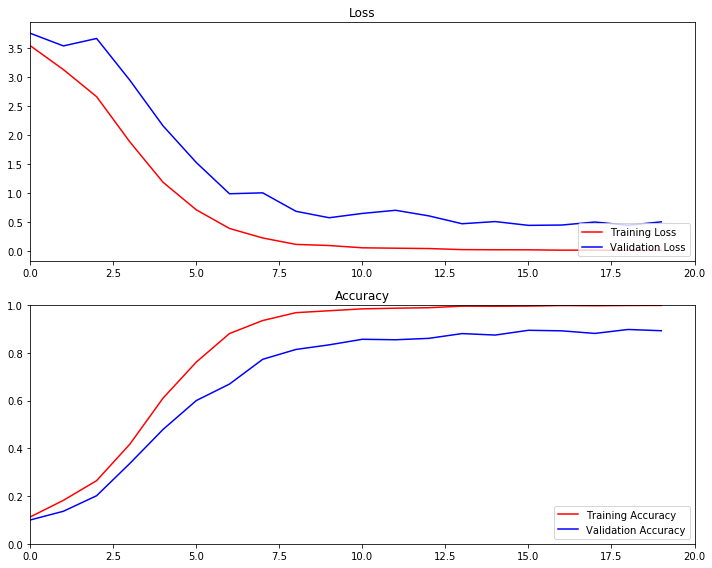

***************************************************
global start time 2017-04-29 00:21:05.543593, end time 2017-04-29 02:51:45.492942 total run time 2:30:39.949349


In [92]:
"""
Previous trial has very small training loss but validation loss is not decreasing.
Validation accuracy hovers around 92%.  It looks like it's overfitting.
To speed up training, I will only calculate loss/accuracy every 10 batches
I also did a different re-scaling: so global min is -1 and global max is +1 (within training data, or within
validation data, etc).

Looks like this type of re-scaling does worse than when I scale each image to have min/max -1, 1.

Cutting down the validation checking reduced the epoch runtime to 7 minutes per epoch (instead of 14.5 minutes)

"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 1024

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 15

start time 2017-04-29 02:55:24.308866.  Training...

*********************************

Average for Epoch  1: Training loss = 3.7263, accuracy = 0.1926; Validation loss = 4.2790, accuracy = 0.1803

*********************************

end time 2017-04-29 03:04:34.768085; runtime 0:09:10.459219
start time 2017-04-29 03:04:34.771632.  Training...

*********************************

Average for Epoch  2: Training loss = 2.0845, accuracy = 0.3592; Validation loss = 2.4507, accuracy = 0.3125

*********************************

end time 2017-04-29 03:13:45.590748; runtime 0:09:10.819116
start time 2017-04-29 03:13:45.593635.  Training...

*********************************

Average for Epoch  3: Training loss = 1.8610, accuracy = 0.4214; Validation loss = 2.3895, accuracy = 0.3660

*********************************

end time 2017-04-29 03:22:57.727260; runtime 0:09:12.133625
start time 2017-04-29 03:22:57.729981.  Training...

*********************************

Average for Epoch  4: Training lo

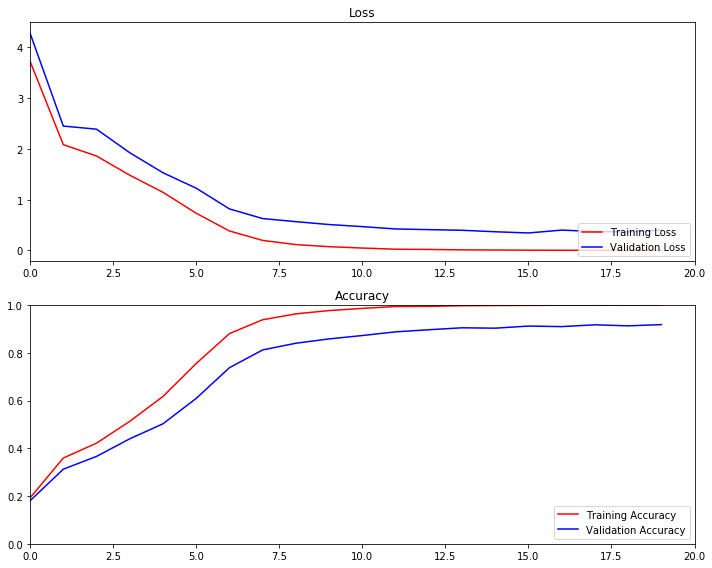

***************************************************
global start time 2017-04-29 02:55:22.604200, end time 2017-04-29 05:53:41.753505 total run time 2:58:19.149305


In [100]:
"""
Go back to scaling each image between -1 and +1, as in trial 13.
original 3 colors.
cnn layers: 64, 128, 256 (trial 13 had 64,128,128), fc layers 2048, 2048, 2048
remove all batch validation print statements to reduce runtime as much as possible.
batch size 2048 to run faster

It does worse with the bigger cnn.

Average for Epoch 20: Training loss = 0.0027, accuracy = 0.9992; Validation loss = 0.3994, accuracy = 0.9179

*********************************

end time 2017-04-29 05:53:31.631272; runtime 0:08:53.145070
epoch 20, saved graph./model_original_data_epoch_20
"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 17

start time 2017-04-29 18:11:03.676583.  Training...
epoch 1/2

*********************************

Average for Epoch  1: Training loss = 1.2430, accuracy = 0.6067; Validation loss = 1.6172, accuracy = 0.5229

*********************************

end time 2017-04-29 18:19:34.841095; runtime 0:08:31.164512
start time 2017-04-29 18:19:34.843611.  Training...
epoch 2/3

*********************************

Average for Epoch  2: Training loss = 0.4340, accuracy = 0.8681; Validation loss = 0.7970, accuracy = 0.7460

*********************************

end time 2017-04-29 18:28:09.166561; runtime 0:08:34.322950
start time 2017-04-29 18:28:09.169203.  Training...
epoch 3/4

*********************************

Average for Epoch  3: Training loss = 0.1484, accuracy = 0.9582; Validation loss = 0.4974, accuracy = 0.8474

*********************************

end time 2017-04-29 18:36:50.267471; runtime 0:08:41.098268
start time 2017-04-29 18:36:50.270004.  Training...
epoch 4/5

****************************

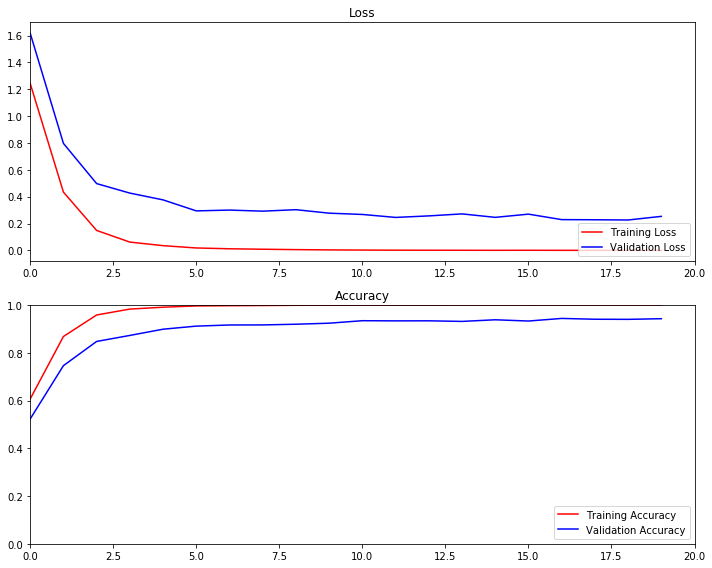

***************************************************
global start time 2017-04-29 18:11:02.222055, end time 2017-04-29 21:13:04.258811 total run time 3:02:02.036756


In [49]:
"""
I'm going to try a smaller CNN: 64, 128, 256, fc: 2048, 1024 (only 2 fc layers, and the later fc layers
are smaller, which I haven't tried before.  But VGG arcitecture has a 4096 fc followed by 1000 fc).
data is scaled per image (so each image min/max is -1,1).
dropout 0.50.  using all 3 colors (no greyscale).  Using original data only.
So, the only real change here is that I have 2 fc instead of 3,
and importantly, I made the 2nd fc smaller than the first, so it's narrowing down the layer
size as it reaches the logits layer.

Average for Epoch 20: Training loss = 0.0002, accuracy = 1.0000; Validation loss = 0.2533, accuracy = 0.9426

"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50

epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate_original(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           save_file_prefix='model_original_data')

## Trial 18

************************************************************************************************************************
epoch 1
start time 2017-04-29 23:54:15.337688
Fraction transformed is 0.10, Training...
------------------------------------------------------------------------------------------------------------------------
Average for Epoch  1: Training loss = 1.3179, accuracy = 0.5863; Validation loss = 1.8029, accuracy = 0.4710
------------------------------------------------------------------------------------------------------------------------
end time 2017-04-30 00:03:31.778405; runtime 0:09:16.440717
************************************************************************************************************************

************************************************************************************************************************
epoch 2
start time 2017-04-30 00:03:31.781115
Fraction transformed is 0.10, Training...
-------------------------------------------------

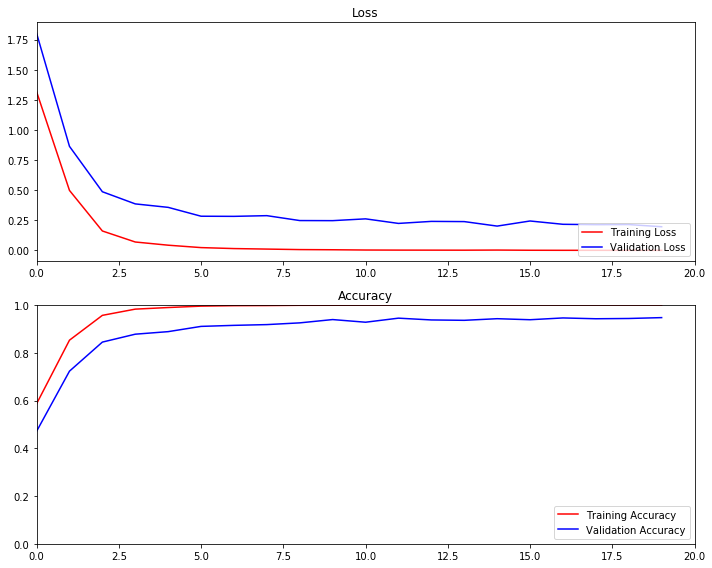

***************************************************
global start time 2017-04-29 23:54:13.676571, end time 2017-04-30 03:05:49.951604 total run time 3:11:36.275033


In [87]:
"""

Now that I got 94% accuracy with original data, I will try with transformed data.
cnn: 64, 128, 256; fc 2048, 1024. keep_prob 0.50; learning rate 0.01. 3 colors (no greyscale)

I'm transforming 10% of the data for each epoch.  
No changes in the transformation rate as we iterate over epochs

It seems to reach 94pc accuracy sooner, around epoch 12, compared to Trial 17 (epoch 17).

Average for Epoch 20: Training loss = 0.0005, accuracy = 0.9999; Validation loss = 0.1964, accuracy = 0.9472
"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50
FRACTION_TRANSFORM = 0.10 #and stays at 0.10 for all epochs
epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform = 0.10,
                           save_file_prefix='model_original_data')

## Trial 19

In [ ]:
"""


cnn: 64, 128, 256; fc 2048, 1024. keep_prob 0.50; learning rate 0.01. 3 colors (no greyscale)

I'm transforming 50% of the data for each epoch.  
No changes in the transformation rate as we iterate over epochs




"""
EPOCHS=20
LEARNING_RATE = 0.01
TRAIN_KEEP_PROB = 0.50
FRACTION_TRANSFORM = 0.10 #and stays at 0.10 for all epochs
epoch_start = 1
epoch_end = EPOCHS
batch_size = 2048

iterate_train_evaluate(epoch_start,epoch_end,
                           X_train,y_train,
                           X_valid,y_valid,
                           batch_size,
                           fraction_transform = 0.10,
                           save_file_prefix='model_original_data')

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")